In [8]:
import torch
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.fft import fft2, ifft2, fftshift, ifftshift

In [7]:
# Define the model to be fine-tuned (37 classes for Oxford-IIIT Pet)
class Model(nn.Module):
    def __init__(self, device, num_classes=37):
        super(Model, self).__init__()
        self.model = models.resnet50(pretrained=True)
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)
        self.model = self.model.to(device)
    
    def forward(self, x):
        x = self.model(x)
        x = F.softmax(x, dim=1)
        return x

In [6]:
# Load Oxford-IIIT Pet training data
def load_pets_train(batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    dataset = datasets.OxfordIIITPet(
        root="./data", 
        split="trainval", 
        target_types="category", 
        transform=transform, 
        download=True
    )
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    return loader

def load_pets_test(batch_size=16):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    dataset = datasets.OxfordIIITPet(
        root="./data", 
        split="test", 
        target_types="category", 
        transform=transform, 
        download=True
    )
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    return loader

def fine_tune_model(model, train_loader, device, num_epochs=5):
    model.train()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    
    return model

def display_images(original, adversarial):
    """Display last batch of original and adversarial images."""
    original = original.clamp(0, 1)
    adversarial = adversarial.clamp(0, 1)

    fig, axes = plt.subplots(2, len(original), figsize=(16, 10))
    
    for i in range(len(original)):
        orig_img = original[i].permute(1, 2, 0).cpu().numpy()
        adv_img = adversarial[i].permute(1, 2, 0).cpu().numpy()

        axes[0, i].imshow(orig_img)
        axes[0, i].axis("off")

        axes[1, i].imshow(adv_img)
        axes[1, i].axis("off")

    plt.show()

In [5]:
import torch
import torch.nn as nn
import numpy as np
import torch.fft as fft

class FrequencyPixelAttacks(nn.Module):
    """
    A PyTorch transform to apply various frequency-based and pixel-based attacks.
    """
    def __init__(self, attack_type='phase', epsilon=0.1, frequency_radius=0.1, num_pixels=100, noise_std=0.05, seed=None):
        super(FrequencyPixelAttacks, self).__init__()
        self.attack_type = attack_type
        self.epsilon = epsilon
        self.frequency_radius = frequency_radius
        self.num_pixels = num_pixels
        self.noise_std = noise_std
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
    
    def forward(self, img):
        perturbed_img = img.clone().detach()
        if self.attack_type == 'phase':
            perturbed_img = self._phase_attack(perturbed_img)
        elif self.attack_type == 'magnitude':
            perturbed_img = self._magnitude_attack(perturbed_img)
        elif self.attack_type == 'low_freq':
            perturbed_img = self._low_frequency_attack(perturbed_img)
        elif self.attack_type == 'high_freq':
            perturbed_img = self._high_frequency_attack(perturbed_img)
        elif self.attack_type == 'pixel':
            perturbed_img = self._pixel_attack(perturbed_img)
        elif self.attack_type == 'normal':
            perturbed_img = self._normal_noise_attack(perturbed_img)
        else:
            raise ValueError(f"Unknown attack type: {self.attack_type}")
        return torch.clamp(perturbed_img, 0, 1)
    
    def _phase_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = torch.zeros_like(img)
        for c in range(channels):
            f_transform = fft.fftshift(fft.fft2(img[:, c]))
            magnitude = torch.abs(f_transform)
            phase = torch.angle(f_transform)
            phase_noise = torch.randn_like(phase) * self.epsilon
            perturbed_phase = phase + phase_noise
            f_transform_perturbed = magnitude * torch.exp(1j * perturbed_phase)
            img_perturbed = fft.ifft2(fft.ifftshift(f_transform_perturbed)).real
            perturbed_img[:, c] = img_perturbed
        return perturbed_img
    
    def _magnitude_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = torch.zeros_like(img)
        for c in range(channels):
            f_transform = fft.fftshift(fft.fft2(img[:, c]))
            magnitude = torch.abs(f_transform)
            phase = torch.angle(f_transform)
            magnitude_noise = torch.randn_like(magnitude) * self.epsilon * magnitude
            perturbed_magnitude = magnitude + magnitude_noise
            f_transform_perturbed = perturbed_magnitude * torch.exp(1j * phase)
            img_perturbed = fft.ifft2(fft.ifftshift(f_transform_perturbed)).real
            perturbed_img[:, c] = img_perturbed
        return perturbed_img
    
    def _create_frequency_mask(self, height, width, is_low_freq=True):
        y_indices, x_indices = torch.meshgrid(torch.arange(height), torch.arange(width), indexing='ij')
        y_indices = y_indices - height // 2
        x_indices = x_indices - width // 2
        distance = torch.sqrt(y_indices**2 + x_indices**2).float()
        max_distance = torch.sqrt(torch.tensor(height**2 + width**2, dtype=torch.float32))
        distance /= max_distance
        return (distance <= self.frequency_radius).float() if is_low_freq else (distance >= (1 - self.frequency_radius)).float()
    
    def _low_frequency_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = torch.zeros_like(img)
        mask = self._create_frequency_mask(height, width, is_low_freq=True).to(img.device)
        for c in range(channels):
            f_transform = fft.fftshift(fft.fft2(img[:, c]))
            noise = (torch.randn_like(f_transform.real) + 1j * torch.randn_like(f_transform.imag)) * self.epsilon
            f_transform_perturbed = f_transform + noise * mask
            img_perturbed = fft.ifft2(fft.ifftshift(f_transform_perturbed)).real
            perturbed_img[:, c] = img_perturbed
        return perturbed_img
    
    def _high_frequency_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = torch.zeros_like(img)
        mask = self._create_frequency_mask(height, width, is_low_freq=False).to(img.device)
        for c in range(channels):
            f_transform = fft.fftshift(fft.fft2(img[:, c]))
            noise = (torch.randn_like(f_transform.real) + 1j * torch.randn_like(f_transform.imag)) * self.epsilon
            f_transform_perturbed = f_transform + noise * mask
            img_perturbed = fft.ifft2(fft.ifftshift(f_transform_perturbed)).real
            perturbed_img[:, c] = img_perturbed
        return perturbed_img
    
    def _pixel_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = img.clone()
        num_pixels = min(self.num_pixels, height * width)
        pixel_indices = torch.randint(0, height * width, (batch, num_pixels))
        y_indices, x_indices = pixel_indices // width, pixel_indices % width
        for b in range(batch):
            for c in range(channels):
                for i in range(num_pixels):
                    perturbed_img[b, c, y_indices[b, i], x_indices[b, i]] += torch.randn(1).item() * self.epsilon
        return perturbed_img
    
    def _normal_noise_attack(self, img):
        noise = torch.randn_like(img) * self.noise_std
        return img + noise


In [2]:
def display_image(original, adversarial):
    """Display last batch of original and adversarial images."""
    fig, axes = plt.subplots(2, len(original), figsize=(16, 10))
    
    for i in range(len(original)):
        orig_img = original[i].permute(1, 2, 0).cpu().numpy()
        adv_img = adversarial[i].permute(1, 2, 0).cpu().numpy()
        
        orig_img = np.clip(orig_img, 0, 1)
        adv_img = np.clip(adv_img, 0, 1)

        
        axes[0, i].imshow(orig_img)
        axes[0, i].axis("off")

        axes[1, i].imshow(adv_img)
        axes[1, i].axis("off")

    plt.show()
    
def train_adversary(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1. Freeze the model (so only adversary parameters are updated)
    for param in model.parameters():
        param.requires_grad = False
    model.eval()
    
    # 2. Evaluate adversarial attack on test data
    test_loader = load_pets_test(batch_size=1)  # Load test dataset
    test_dataset = test_loader.dataset  # Get dataset without batching

    attacks = [
        {'attack_type': 'phase', 'epsilon': 0.1, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'phase_weak'},
        {'attack_type': 'phase', 'epsilon': 0.5, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'phase_strong'},
        {'attack_type': 'magnitude', 'epsilon': 0.1, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'magnitude_weak'},
        {'attack_type': 'magnitude', 'epsilon': 0.5, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'magnitude_strong'},
        {'attack_type': 'low_freq', 'epsilon': 0.2, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'low_freq_small_radius'},
        {'attack_type': 'low_freq', 'epsilon': 0.2, 'frequency_radius': 0.3, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'low_freq_large_radius'},
        {'attack_type': 'high_freq', 'epsilon': 0.2, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'high_freq_small_radius'},
        {'attack_type': 'high_freq', 'epsilon': 0.2, 'frequency_radius': 0.3, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'high_freq_large_radius'},
        {'attack_type': 'pixel', 'epsilon': 0.5, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'pixel_few'},
        {'attack_type': 'pixel', 'epsilon': 0.5, 'frequency_radius': 0.1, 'num_pixels': 1000, 'noise_std': 0.05, 'name': 'pixel_many'},
        {'attack_type': 'normal', 'epsilon': 0.1,  'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'normal_weak'},
        {'attack_type': 'normal', 'epsilon': 0.1, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.2, 'name': 'normal_strong'}
    ]

    for attack in attacks:
        total_correct_original = 0
        total_correct_perturbed = 0
        total_samples = 0
        last_batch_images = []
        last_batch_perturbed = []
        
        adversary = FrequencyPixelAttacks(attack["attack_type"], attack["epsilon"], attack["frequency_radius"], attack["num_pixels"], attack["noise_std"])

        # Process each image individually
        for i in range(len(test_dataset)):
            image, label = test_dataset[i]  # Get single image and label
            image, label = image.to(device).unsqueeze(0), torch.tensor([label]).to(device)  # Add batch dimension

            # image = image.squeeze(0)  # Removes the batch dimension
            perturbed_image = adversary(image)
            
            with torch.no_grad():
                y_hat = model(image)
                y_pred = model(perturbed_image)
            
            pred_original = torch.argmax(y_hat, dim=1)
            pred_perturbed = torch.argmax(y_pred, dim=1)
            
            total_correct_original += (pred_original == label).item()
            total_correct_perturbed += (pred_perturbed == label).item()
            total_samples += 1  # Each image is processed individually
            
            if i < 5:  # Store only a few images for visualization
                last_batch_images.append(image.cpu().squeeze(0))
                last_batch_perturbed.append(perturbed_image.cpu().squeeze(0))

        original_acc = (total_correct_original / total_samples) * 100
        perturbed_acc = (total_correct_perturbed / total_samples) * 100
    
        print(f"Attack: {attack['name']}")
        print("Total Samples: ", total_samples)
        print(f"Accuracy on Original Images: {original_acc:.2f}%")
        print(f"Accuracy on Perturbed Images: {perturbed_acc:.2f}%")

        display_image(last_batch_images, last_batch_perturbed)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(device, num_classes=37)
train_loader = load_pets_train(batch_size=32)
# # 1. Create and fine-tune the model on training data
print("Fine-tuning the model on Oxford-IIIT Pet training data...")
# model = fine_tune_model(model, train_loader, device, num_epochs=5)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s]


100%|██████████| 792M/792M [00:03<00:00, 212MB/s]  


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:00<00:00, 94.8MB/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet
Fine-tuning the model on Oxford-IIIT Pet training data...


In [3]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
data_dir = "./data"
train_dataset = datasets.OxfordIIITPet(root=data_dir, split='trainval', target_types='category', transform=transform, download=True)
test_dataset = datasets.OxfordIIITPet(root=data_dir, split='test', target_types='category', transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load pretrained ViT model
model = timm.create_model("vit_large_patch16_224", pretrained=True, num_classes=len(train_dataset.classes))
model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Training loop
def train(model, train_loader, criterion, optimizer, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        print(f"Epoch {epoch+1}: Loss {total_loss/len(train_loader):.4f}, Accuracy {100. * correct/total:.2f}%")

# Run training
train(model, train_loader, criterion, optimizer, epochs=5)

# Save the trained model
torch.save(model.state_dict(), "vitb_pets.pth")

100%|██████████| 792M/792M [00:27<00:00, 29.1MB/s] 


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:01<00:00, 12.2MB/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Epoch 1: Loss 0.7785, Accuracy 79.13%
Epoch 2: Loss 0.1652, Accuracy 94.84%
Epoch 3: Loss 0.1238, Accuracy 96.30%
Epoch 4: Loss 0.0780, Accuracy 97.74%
Epoch 5: Loss 0.0534, Accuracy 98.45%


Attack: phase_weak
Total Samples:  3669
Accuracy on Original Images: 86.37%
Accuracy on Perturbed Images: 74.82%


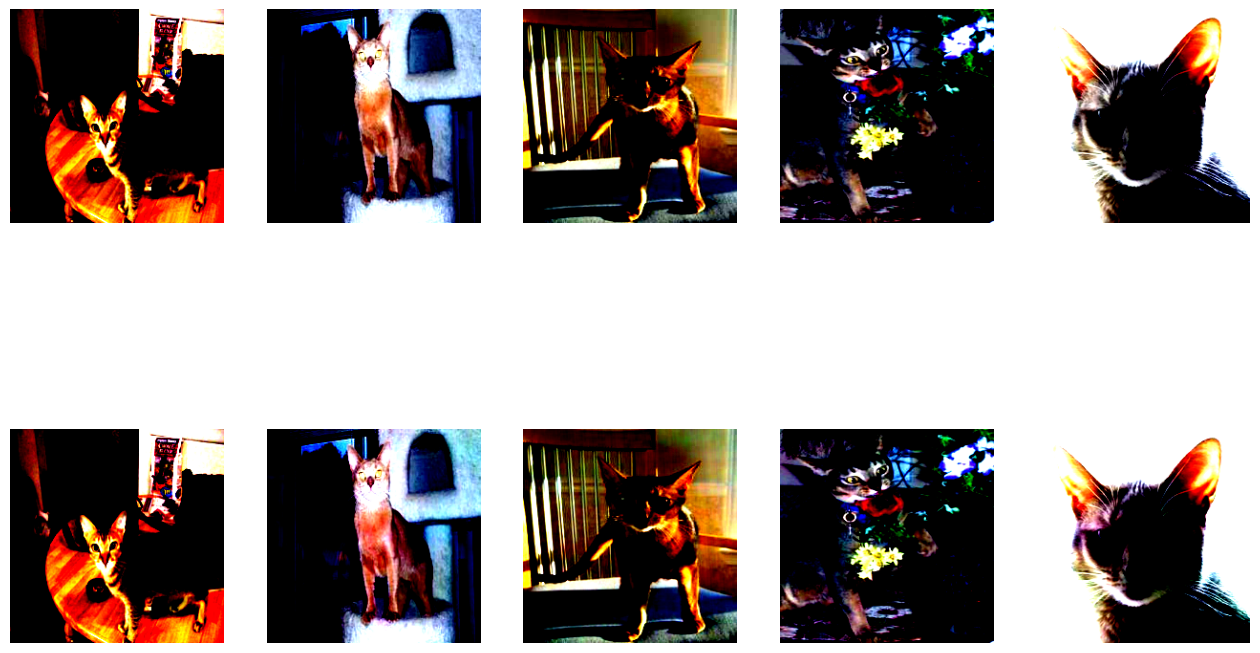

Attack: phase_strong
Total Samples:  3669
Accuracy on Original Images: 86.37%
Accuracy on Perturbed Images: 66.61%


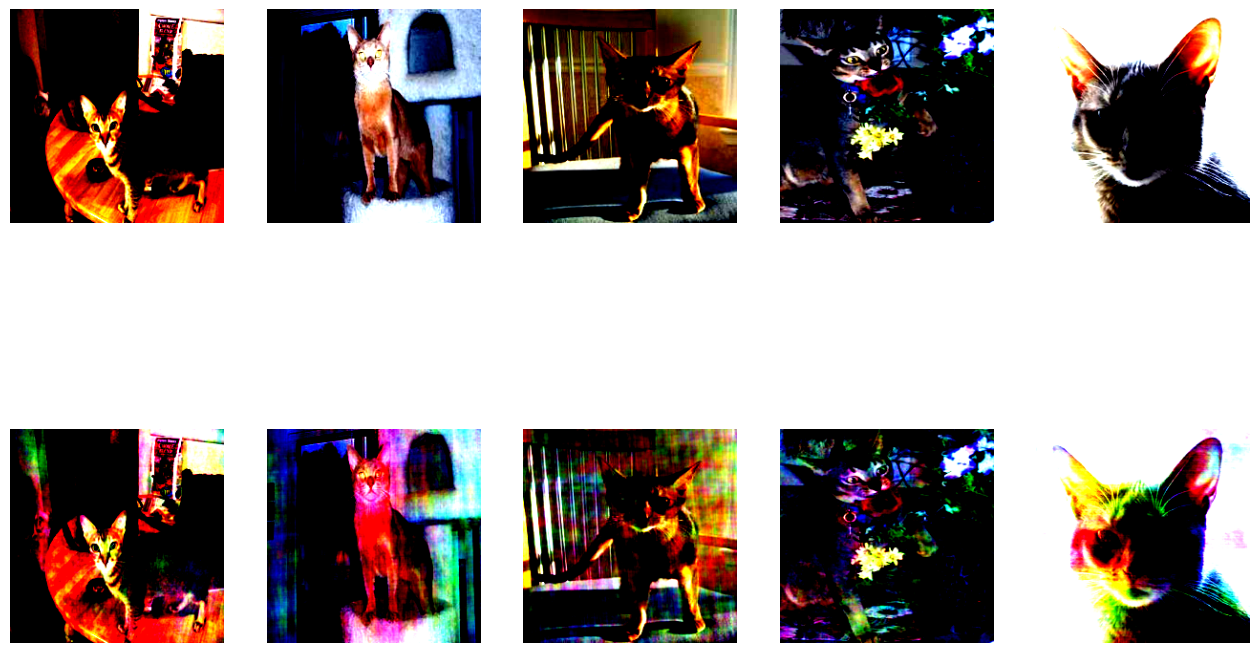

Attack: magnitude_weak
Total Samples:  3669
Accuracy on Original Images: 86.37%
Accuracy on Perturbed Images: 75.09%


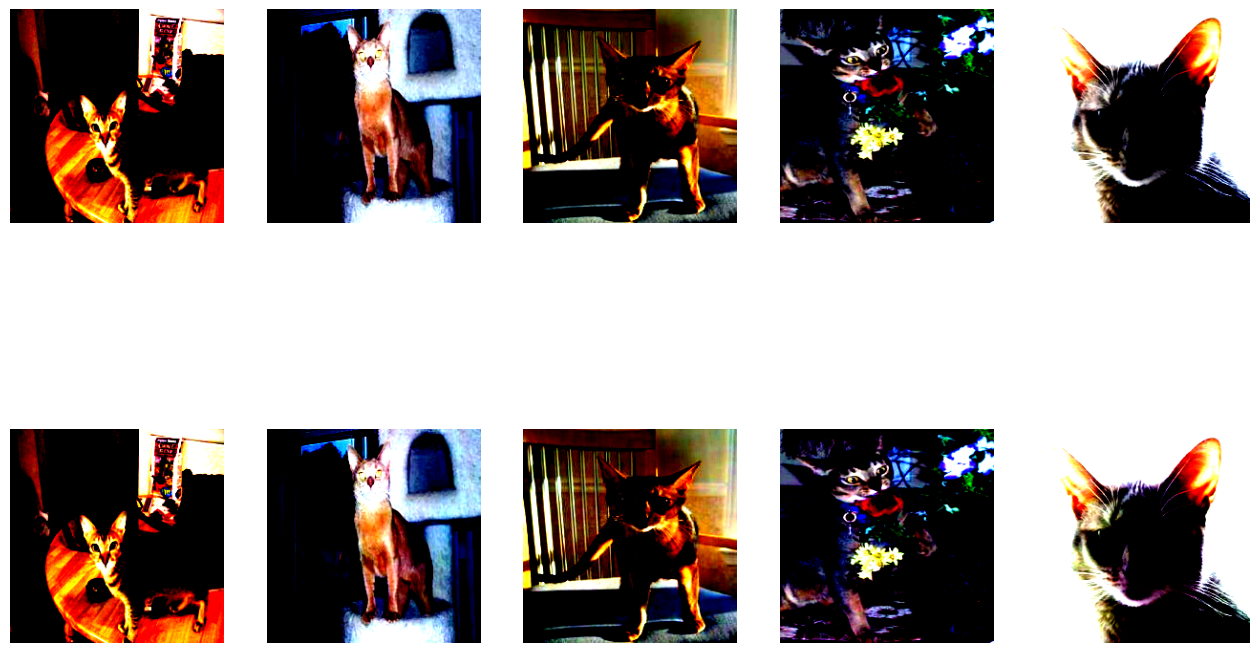

Attack: magnitude_strong
Total Samples:  3669
Accuracy on Original Images: 86.37%
Accuracy on Perturbed Images: 68.30%


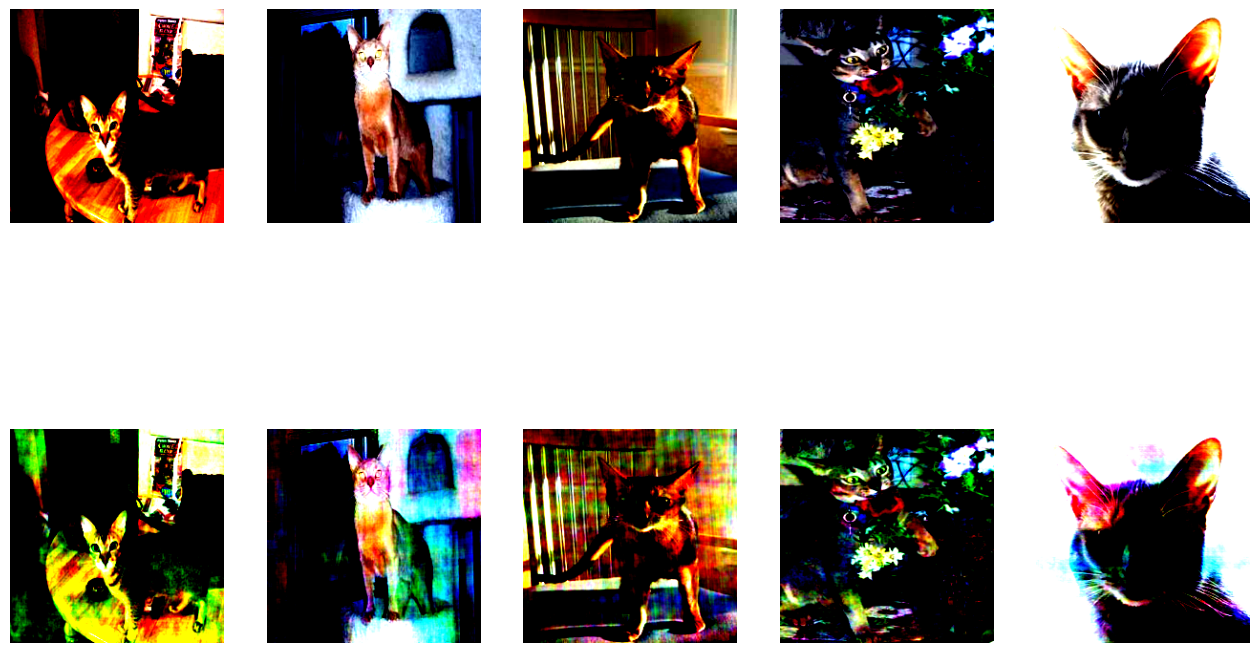

Attack: low_freq_small_radius
Total Samples:  3669
Accuracy on Original Images: 86.37%
Accuracy on Perturbed Images: 75.14%


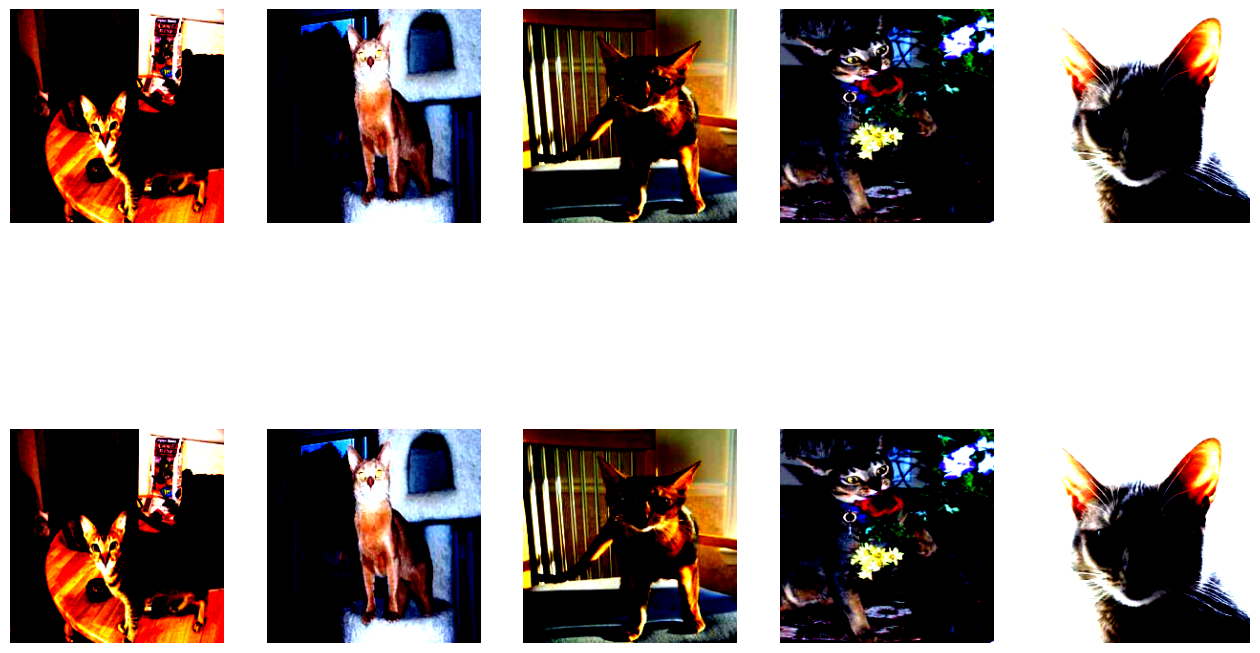

Attack: low_freq_large_radius
Total Samples:  3669
Accuracy on Original Images: 86.37%
Accuracy on Perturbed Images: 75.14%


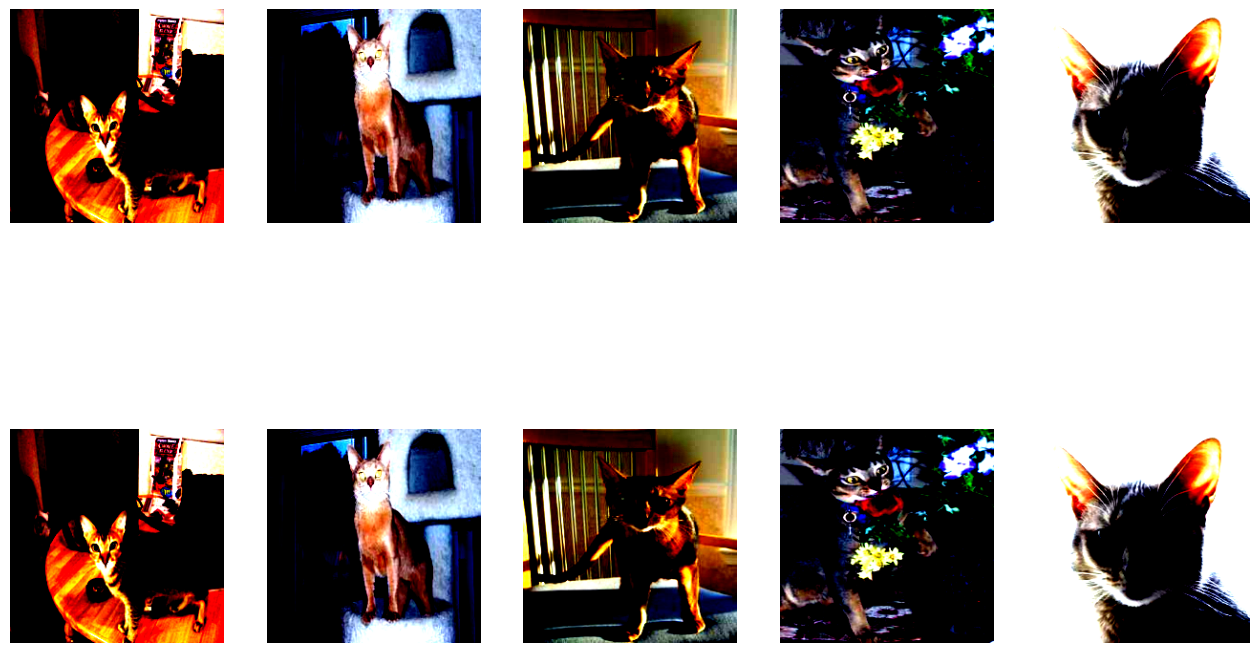

Attack: high_freq_small_radius
Total Samples:  3669
Accuracy on Original Images: 86.37%
Accuracy on Perturbed Images: 75.14%


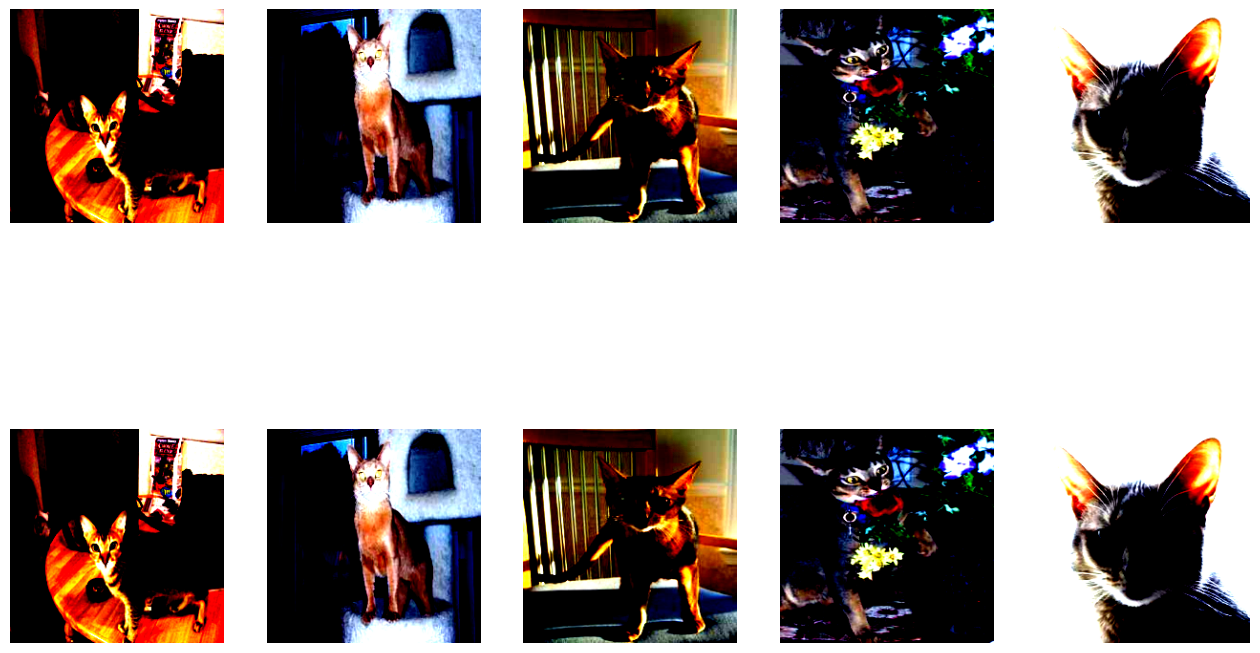

Attack: high_freq_large_radius
Total Samples:  3669
Accuracy on Original Images: 86.37%
Accuracy on Perturbed Images: 75.14%


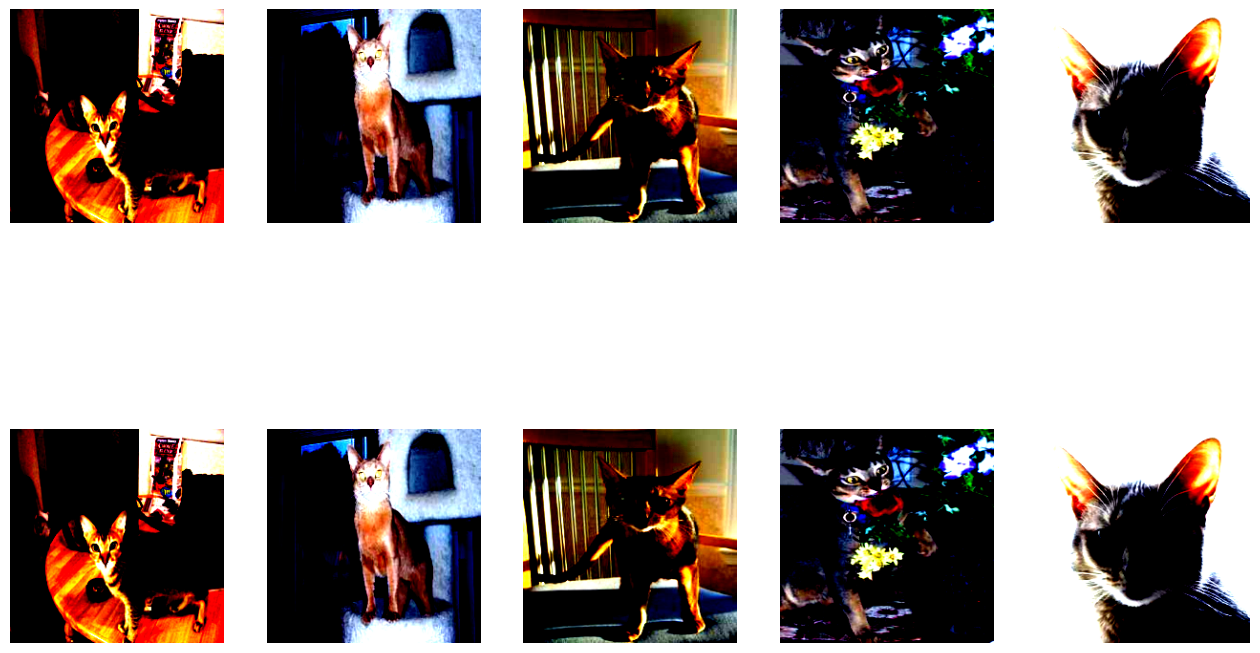

Attack: pixel_few
Total Samples:  3669
Accuracy on Original Images: 86.37%
Accuracy on Perturbed Images: 75.03%


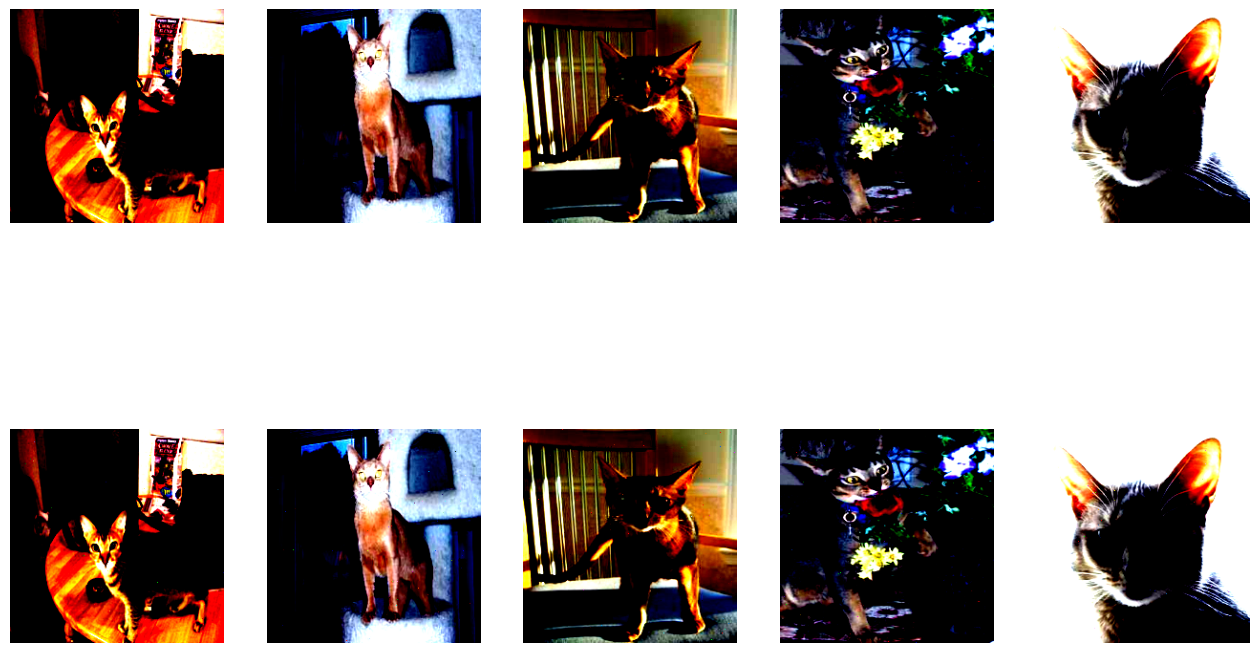

In [ ]:
train_adversary(model)